# The Ising Model

In this notebook we will explore an example of Monte Carlo techniques through the study of the Ising model.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Globally fix plot styling
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

## Ising Model

One example of a Monte Carlo simulation comes from the study of the Ising model. The Ising model provides a simple way of examining how magnetic systems behave - in particular ferromagnets - as well as other systems described by the same mathematics (such as some fluids or gasses). The basic idea is to model the behavior of the system as spins on a lattice where each spin can interact with its nearest neighboring spins.

Here we will work with such a lattice in two dimensions. The lattice in this case is simply a grid, or matrix, containing values of either +1 (spin up) or -1 (spin down). The lattice is represented symbolically using the variable $\sigma(i,j)$, where $i$ and $j$ label coordinates on the lattice (or equivalently, matrix components).

Physically, such systems prefer to have adjacent spins aligned.  This can be achieved by defining an energy function which is minimized when nearby spins have the same value. This principle of minimizing the energy is commonly applied to other physical systems and is a prevalent idea in physics.

For our simple model here the energy of the system will thus be determined by the coupling of a spin with its nearest neighbors.  We can go a step further and also model the lattice of spins in the presence of an external magnetic field represented by the parameter  $\mu$.  A spin in a magnetic field prefers to align with the direction of magnetic field; the misalignment of the spin and the magnetic field will come at the cost of higher energy in the system.  Putting these ideas together the energy of the system can be written as

$$ E = -J\sum_{i,j}\sigma(i, j)\left[\sigma(i+1, j) + \sigma(i-1, j) + \sigma(i, j+1) + \sigma(i,j-1)\right] - \mu \sum_{i,j} \sigma(i,j), $$

where $J \geq 0$ is the strength of interactions between spins (so for larger values of $J$, the more the spins will prefer to be aligned). Note that the energy will be lowest (most negative) when all spins have the same value and the same sign as $\mu$. Also note that, because this energy function relies on computing values of adjacent spins we will need to decide how to handle spins on the boundary of the lattice.  This will be discussed below.

The general procedure we will use to simulate this system is known as the "Metropolis algorithm". Given a starting lattice of spins, we choose a random point ($i$, $j$). Next we decide whether or not to flip the spin at this chosen point using the following algorithm:

- If flipping the spin would result in a decrease in total energy of the system,  $\Delta E = E_\curvearrowright - E_\oslash < 0$, flip the spin.
- If not, flip the spin with a probability $\mathrm{e}^{-\Delta E/T}$, where $T$ is the temperature of the system.

Here $E_\oslash$ represents the energy of the system when the spin is not flipped ($\oslash$ representing "not flipped", this is the energy of the system before we apply the Metropolis algorithm) and  $E_\curvearrowright$ represents the energy the system will have if a spin is flipped (using the symbol $\curvearrowright$ to represent "flipped").  The time evolution of the system is modeled by repeatedly applying the Metropolis algorithm to determine how the spins behave.

### Evolution

To study the evolution we first need to generate an initial lattice. In principle any lattice containing values $\pm 1$ can be used.  We will begin with a randomized lattice which corresponds to an unmagnetized material. We can represent an $N\times N$ lattice simply by using a 2-d array. 

We first define a function `random_lattice(N)` that accepts the parameter $N$, and returns a square matrix filled with random values $\pm 1$. The module `numpy.random` contains a few functions for generating such a lattice.  The most obvious function to consider is `np.random.randint`. You should read the documentation to see how the upper limit of the range is treated. From this, we can generate a random $50\times 50$ lattice, and use `imshow` to produce a quick plot of this lattice.

Some lattice values are: [-1  1 -1  1 -1 -1  1 -1 -1  1  1 -1 -1 -1  1  1  1 -1  1  1  1 -1 -1  1
  1 -1 -1 -1  1 -1 -1  1  1  1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1  1  1  1
  1  1]


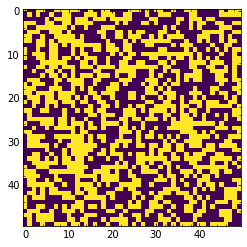

In [12]:
def random_lattice(N) :
    """
    Generate and return a NxN randomly filled with +/-1.
    """
    # Since we are using randint the upper limit is NOT included
    # in the possible outcomes, so we set high=1+1.
    return np.random.randint(low=0, high=1+1, size=(N,N))*2-1

lattice = random_lattice(50)
print("Some lattice values are:", lattice[1])
plt.imshow(lattice)

In the Metropolis algorithm we pick a random point and decide whether or not to flip the spin based on the change in energy.  Thus we need to write a function to calculate $\Delta E$ given a spin flip at a point ($i_f$, $j_f$), for some choice of integers $i_f, j_f \in [0, N-1]$. At first glance this looks tedious; the energy defined above contains sums over the entire lattice.  However, since we are only considering flipping a single spin, all of them will remain the same *except* at the point being flipped.  This means that since we are interested in the change in the energy, not the energy itself, most of the terms in the sum will cancel and $\Delta E$ will be a much simpler expression than we may have feared.  To see this, notice that if we flip the spin at $(i_f, j_f)$ the terms which *will not cancel* in the energy are given by
\begin{align}
E^{\rm non-canceling}_\curvearrowright & = -J\sigma_\curvearrowright(i_f,j_f)\left[\sigma(i_f+1,j_f) + \sigma(i_f-1,j_f) + \sigma(i_f,j_f+1) + \sigma(i_f,j_f-1)\right] \\ 
 & {} - J\sigma(i_f+1,j_f)\sigma_\curvearrowright(i_f,j_f) - J\sigma(i_f-1,j_f)\sigma_\curvearrowright(i_f,j_f) - J\sigma(i_f,j_f+1)\sigma_\curvearrowright(i_f,j_f) \\
 & {} - J\sigma(i_f,j_f-1)\sigma_\curvearrowright(i_f,j_f) - \mu \sigma_\curvearrowright(i_f,j_f) \\
 &= -2J\sigma_\curvearrowright(i_f,j_f)\left[\sigma(i_f+1,j_f) + \sigma(i_f-1,j_f) + \sigma(i_f,j_f+1) + \sigma(i_f,j_f-1)\right] - \mu \sigma_\curvearrowright(i_f, j_f) \\
\end{align}

Similarly, if we do not flip the spin then the non-canceling terms in the non-flipping energy will be exactly the same as those given above if we just replace $\curvearrowright$ with $\oslash$. Finally, since flipping the spin is equivalent to multiplying by $-1$ this means that $\sigma_\curvearrowright = -\sigma_\oslash$ and the difference in energy between flipping and not flipping the spin at $(i_f,j_f)$ is
$$\Delta E \equiv E_\curvearrowright - E_\oslash = 4J\sigma_\oslash(i_f,j_f)\left[\sigma(i_f+1,j_f) + \sigma(i_f-1,j_f) + \sigma(i_f,j_f+1) + \sigma(i_f,j_f-1)\right] + 2\mu\sigma_\oslash(i_f,j_f) \,.$$
This is the quantity we need in the Metropolis algorithm to help determine whether or not to flip a spin when the energy would increase if the spin is flipped.

#### Boundary Conditions

We are not quite done, we need to know how the system behaves on the lattice boundaries. Since $i_f, j_f \in [0, N-1]$, how do we calculate $E$ when $i_f$ or $j_f$ are $0$ or $N-1$? To resolve this we employ periodic boundary conditions meaning that $\sigma(-1,j_f) = \sigma(N-1,j_f)$, $\sigma(N,j_f) = \sigma(0,j_f)$, $\sigma(i_f,-1) = \sigma(i_f,N-1)$, and $\sigma(i_f,N) = \sigma(i_f,0)$. One simple way to implement this is to use modular arithmetic on the index values which allows increasing numbers to "wrap around" in the way we need. In Python (and in many languages), the mod function is implemented using the `%` operator, so $a \pmod b$ = `a % b`. If you are unfamiliar with modular arithmetic, the [wikipedia page](http://en.wikipedia.org/wiki/Modular_arithmetic) should help you catch up. For our purposes, it will suffice to mod the index values of each spin in the lattice by $N$ after adding or subtracting `1` from them. You should verify that running `-1%N` will return `N-1`, and `N%N` will return `0`. (*Warning:* languages other than Python may behave differently when modding negative numbers!  In some such languages `-1%N` is equal to `-1`.  Since `N%N` is always `0` it is safe to add `N` to any expression before using modular arithmetic.  In other words, it is always safe to write `(i-1+N)%N` and this will work in languages that treat negative numbers differently than Python.)

Below we define a function that accepts a lattice, the parameters $J$ and $\mu$, and the index values of a point, $i_f$ and $j_f$; and returns $\Delta E$.

In [13]:
def DeltaE(lattice, J, mu, i_f, j_f) :
    old_s = lattice[i_f,j_f]
    N = lattice.shape[0]
    
    # Here we use the trick of modding the values by N, using %N returns
    # values "wrapped around", or periodic boundaries!
    s_p0 = lattice[(i_f+1)%N,j_f]
    s_m0 = lattice[(i_f-1)%N,j_f]
    s_0p = lattice[i_f,(j_f+1)%N]
    s_0m = lattice[i_f,(j_f-1)%N]
    
    return 4.0*old_s*J*(s_p0 + s_m0 + s_0p + s_0m) + 2.0*mu*old_s

#### Metropolis Algorithm

We are finally ready to implement the Metropolis algorithm as described above.  We will use this to evolve the system by repeatedly applying it to a random lattice.  Here we write a function that implements the algorithm.

Below is a function that accepts a lattice, picks a random point in it, and flips the spin at that point according to the Metropolis algorithm. This means that if $\Delta E < 0$, then the transition is favored and the spin should be flipped at the given point. On the other hand, if $\Delta E > 0$, then the spin may or may not be flipped based on the probability $\exp(-\Delta E/T)$. This function accepts the lattice and the model parameters $J$, $\mu$, and $T$.

This function changes `lattice` but does not return anything.  A function that changes one of its inputs is known as a *mutator method*.  We use functions like this when small changes are made to a potentially large input to avoid making copies of it.

To proceed we also need to understand the use of $\exp(-\Delta E/T)$ as a probability.  Note that $0 < \exp(-\Delta E/T) \leq 1$, so it can indeed represent a probability of flipping. When it is stated that the spin should flip with this probability, we mean that the spin should flip, eg, $100\times\exp(-\Delta E/T)$ percent of the time. If $\Delta E$ is zero then we would flip 100 percent of the time.  If $\Delta E$ is very large then we should very rarely flip.  One way to accomplish this is to generate a random number between $0$ and $1$; if this number is less than $\exp(-\Delta E/T)$, flip the spin, if it is not, then leave the spin unchanged.

Finally, flipping the spin in the lattice is quite simple, it just means multiplying the value in the lattice by negative one.

In [14]:
def flip_point(lattice, J, mu, T) :
    """
    Pick a random point in the lattice and determine whether it should
    flip or not based on the Metropolis algorithm.
    If the flip is energetically favorable (DE<0), the flip occurs,
    if not, the spin is flipped with probability exp(-DE/T).
    The spin flip is done in place, so lattice is changed when
    a spin flip occurs.
    """
    N = lattice.shape[0]
    # Pick a random point.  Each coordinate is in the interval [0, N-1]
    pt = np.random.randint(0, N, 2)
    DE = DeltaE(lattice, J, mu, pt[0], pt[1])
    if (DE < 0) :
        # Favored, always flip
        lattice[pt[0], pt[1]] *= -1
    else :
        # Not favored, flip with some probability
        if np.random.random() < np.exp(-DE/T) :
            lattice[pt[0], pt[1]] *= -1

#### Evolving the System

With all this set up we can now evolve a system.  A square lattice with $N=50$ lattice contains $2500$ spins. If we wish for the final state of the system to be representative of the system after a long period of time, we should attempt to flip each point enough times that a spin flip at one point in the lattice has sufficient time to affect spins at points well separated from it. To accomplish this we will attempt to flip each spin approximately $4N$ times on average.

We first evolve an initially random lattice of spins by calling the `flip_point` function $4 N \times N^2 = 500000$ times on it. Here is a case where using a for loop is completely acceptable. Note that this can take a few seconds to run so you may want to try a smaller number of flips. Let $J=1$, $\mu=0$, and $T=3.5$. We plot the final state of the system.

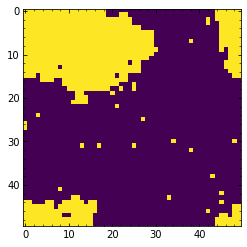

In [8]:
lattice = random_lattice(50)
# Do the evolution
for _ in range(500000) :
    flip_point(lattice, 1, 0, 3.5)

plt.imshow(lattice)

The above image should contain (a) distinct region(s) of the same spins, with some randomly flipped values scattered throughout. This should be somewhat expected as the system is attempting to make nearby spins have similar values. The image should also contain some small regions with dissimilar spins, something to be discussed below.

#### Changing $T$

So far the role of $T$ has not been discussed. As you may have guessed, this corresponds to the "temperature" of the system. A higher temperature will tend to disorder the system, resulting in more random fluctuations in the system - more spin flips. We will test this now.

For a high enough temperature, spins should frequently flip even if the spin flip will cause an increase in energy. The higher the temperature, the more disordered the system should become. We can verify this is the case by evolving another random lattice now using $T=10$ (and keeping $J=1$ and $\mu=0$).

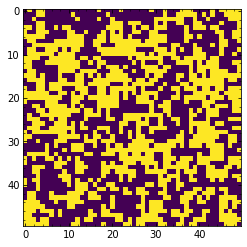

In [9]:
lattice = random_lattice(50)
for _ in range(500000) :
    flip_point(lattice, 1, 0, 10.0)

plt.imshow(lattice)

In the opposite extreme, very low temperature, the system should settle into a near-equilibrium state with regions of similar spins having well-defined borders and few or no random fluctuations. We can verify this by running our code for $T=0.1$.

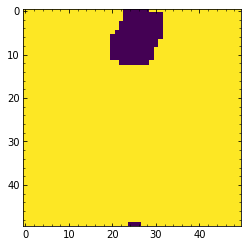

In [15]:
lattice = random_lattice(50)
for _ in range(500000) :
    flip_point(lattice, 1, 0, 0.1)

plt.imshow(lattice)

### Additional Explorations

#### Role of $\mu$

So far we have only considered $\mu=0$.  This is equivalent to a system of spins at some temperature, such as a magnet sitting on a table.  As stated above, $\mu$ represents an external magnetic field and can be used to study spins in such a setting, for example a magnet placed in an external magnetic field.  We know that spins prefer to align with an external magnetic field.  This means if $\mu$ is positive then positive spins (shown in red in our plots) should be preferred.  Explore different choices for $T$ and $\mu$ and see how the system behaves.  For example, we saw above that for $T=10$ the system remain fairly disordered.  What happens if we include a non-zero $\mu$ for this temperature?

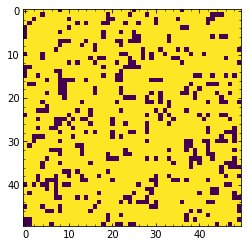

In [13]:
# One example with T=10 and mu=3.
# We should see that the system is more ordered than the mu=0 case with
# the spin up (red state) preferred.

lattice = random_lattice(50)
for _ in range(500000) :
    # mu = 1 means spins should prefer to be positive (shown as red)
    # even at higher temperatures.
    flip_point(lattice, 1, 3, 10.0)
            
plt.imshow(lattice)

#### Animation

Though looking at the final state is nice, it is even better to watch the evolution of the system by animating the evolution.

In [ ]:
# Following the guidance in the link we need the animation and rc
# functions from matplotlib.
from matplotlib import animation, rc

# Create the lattice and initialize the image.
fig, ax = plt.subplots()
lattice = random_lattice(50)
img = ax.imshow(lattice)

# It would be best to encapsulate the code from above in a Python class.
# Instead we will define a function to perform the animation using the global
# lattice and image we create below.
# This accepts mu and T as arguments but assumes J=1.
def animate(i, mu, T) :
    # It is boring watching one spin flip at a time, so flip many each frame
    nflip = 100
    for _ in range(nflip) :
        flip_point(lattice, 1, mu, T)
    img.set_data(lattice)
    ax.set_title(f'Frame {i+1}')
    return img,

# Change fargs to match cases from above and watch them evolve!
anim = animation.FuncAnimation(fig, animate, frames=200, repeat=False,
                               fargs=(3.,10), interval=50, blit=True)
rc('animation', html='jshtml')
anim